# How does directly targeting the predictive distribution compare to BLR?

We consider linear (1D regression) models of the form:$$y_i = \boldsymbol{\beta}^\mathsf{T} \phi(x_i) + \epsilon_i,$$where $\phi : \mathbb{R} \to \mathbb{R}^p$ is a (known) feature map and $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$. The true value of $\boldsymbol{\beta}$ and $\sigma^2$ is unknown and we assume we have an observed a dataset $\mathcal{D}_n = \{(y_i, x_i)\}_{i=1}^n$.

## BLR Inference

For conjugate inference, we take a normal-gamma prior for $\boldsymbol{\beta}$ and $\tau := 1 / \sigma^2$:$$\pi(\boldsymbol{\beta}, \tau) = \mathcal{N}(\boldsymbol{\beta}; \boldsymbol{\mu}_0, (\tau \Lambda_0)^{-1}) \cdot \operatorname{Gam}(\tau; a_0, b_0),$$for $\boldsymbol{\mu}_0 \in \mathbb{R}^p$, $\Lambda_0 \in \mathbb{R}^{p \times p}$ and $a_0, b_0 \in \mathbb{R}^+$. This gives the parameter posterior (*[derivation](https://statproofbook.github.io/P/blr-post.html)*):$$\pi(\boldsymbol{\beta}, \tau \mid \mathcal{D}_n) = \mathcal{N}(\boldsymbol{\beta}; \boldsymbol{\mu}_n, (\tau \Lambda_n)^{-1}) \cdot \operatorname{Gam}(\tau; a_n, b_n),$$where $\boldsymbol{y} = (y_i)_{i=1}^n$ and $X = (\phi(x_i)^\mathsf{T})_{i=1}^n \in \mathbb{R}^{n \times p}$ $$\begin{aligned}
\Lambda_n &= X^\mathsf{T} X + \Lambda_0, \\
\boldsymbol{\mu}_n &= \Lambda_n^{-1}(X^\mathsf{T} \boldsymbol{y} + \Lambda_0 \boldsymbol{\mu}_0), \\
a_n &= a_0 + \frac{n}{2}, \\
b_n &= b_0 + \frac{1}{2} \left( \boldsymbol{y}^\mathsf{T} \boldsymbol{y} + \boldsymbol{\mu}_0^\mathsf{T} \Lambda_0 \boldsymbol{\mu}_0 - \boldsymbol{\mu}_n^\mathsf{T} \Lambda_n \boldsymbol{\mu}_n \right).
\end{aligned}$$
The posterior predictive is a Student's t-distribution (*[derivation](https://bookdown.org/aramir21/IntroductionBayesianEconometricsGuidedTour/linear-regression-the-conjugate-normal-normalinverse-gamma-model.html)*):$$y^* \mid x^*, \mathcal{D}_n \sim t_{2a_n}( \boldsymbol{\mu}_n^\mathsf{T} \phi(x^*), \sigma_n^2)$$where$$\sigma_n^2 = \frac{b_n}{a_n} \left( 1 + \phi(x^*)^\mathsf{T} \Lambda_n^{-1} \phi(x^*) \right).$$


## Directly targeting predictive

We compare the BLR approach to directly targeting the predictive distribution $p(y^* \mid x^*)$ which minimises the NLPD (negative log predictive density) on the training set $\mathcal{D}_n$. We look at different parametric models for the predictive $p(y^* \mid x^*)$.

## Setup

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, gamma, norm, t
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
# MPS (apple silicon support)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [33]:
colors = ["royalblue", "red", "orange"]

## Simple Linear Model

In [34]:
beta = np.array([-0.3, 0.8])  # coefficients
sigma2 = 0.05; sigma = np.sqrt(sigma2)  # noising variance

def phi(x):  # feature map
    n = x.shape[0]
    return np.column_stack((np.ones(n), x))


# Generating training dataset
n = 250
x = np.random.uniform(0, 1, n)
X = phi(x)
y = np.matmul(X, beta) + np.random.normal(0, np.sqrt(sigma2), n)


x_vals = np.linspace(0,1,200)  # x grid for plotting
mu_vals = beta[0] + beta[1]*x_vals

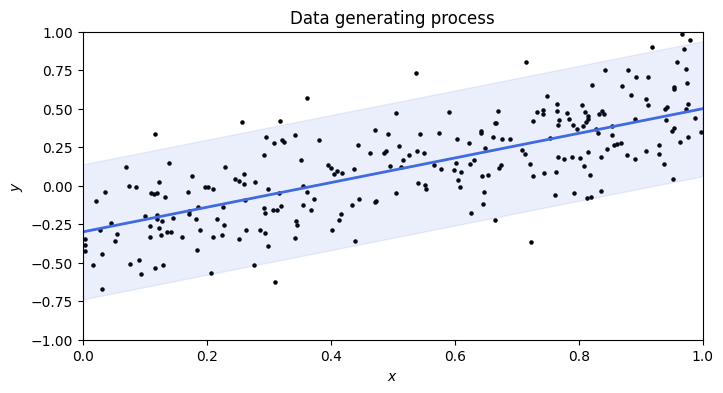

In [35]:
norm_crit = norm.ppf(0.975)

plt.figure(figsize=(8, 4))
plt.scatter(x, y, s=5, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma, mu_vals+norm_crit*sigma, color=colors[0], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="-")
plt.xlim(0,1); plt.ylim(-1,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Data generating process")
plt.show()

#### Negative log probability density (NLPD) under the true data generating distribution

In [36]:
mu = X @ beta
std = np.sqrt(np.ones(n) * sigma2)

true_nlpd = -np.sum([np.log(np.array(
    [norm.pdf(y[i], mu[i], std[i]) for i in range(n)]
))])

print(f"True NLPD: {true_nlpd:.4f}")

True NLPD: -15.9682


### BLR

#### Prior
$$\boldsymbol{\mu}_0 = (0, 0)^\mathsf{T}, \quad \Lambda_0 = \begin{bmatrix}
0.25 & 0 \\
0 & 0.06
\end{bmatrix}, \quad a_0 = 2 \text{ (shape)}, \quad b_0 = 0.1 \text{ (rate)}.$$

In [37]:
mu_0 = np.zeros(2)
Lambda_0 = np.array([[0.25, 0.0], [0.0, 0.06]])
a_0 = 2  # shape
b_0 = 0.1  # rate = 1/scale

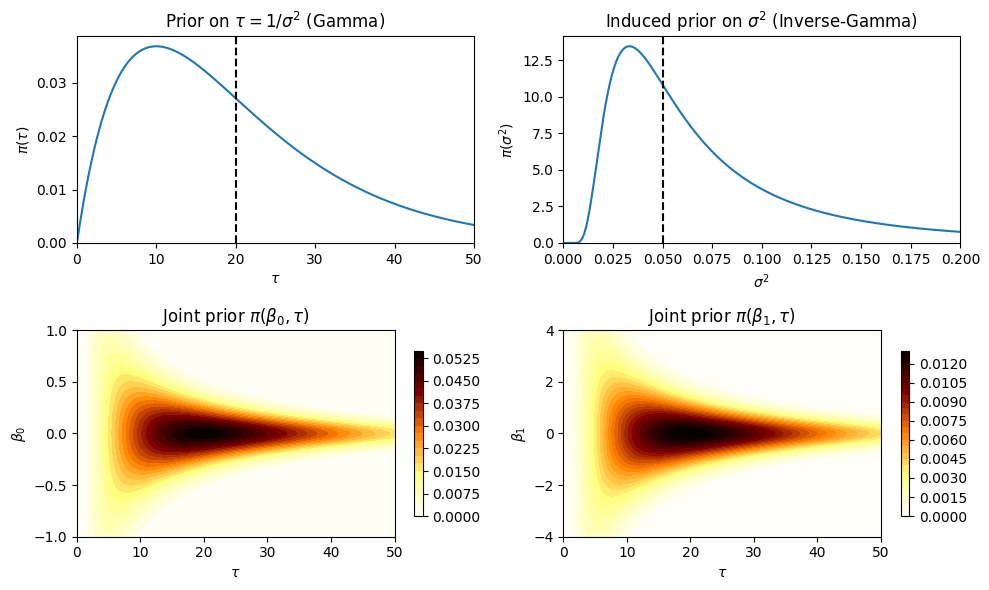

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# prior on tau
tau_vals = np.linspace(0, 50, 1000)
tau_pdf_vals = gamma.pdf(tau_vals, a=a_0, scale=1/b_0)

axs[0, 0].plot(tau_vals, tau_pdf_vals)
axs[0, 0].axvline(x=(1/sigma2), color="black", linestyle="--")
axs[0, 0].set_xlabel(r"$\tau$"); axs[0, 0].set_ylabel(r"$\pi(\tau)$")
axs[0, 0].set_xlim(0, 50); axs[0, 0].set_ylim(0)
axs[0, 0].set_title(r"Prior on $\tau = 1 / \sigma^2$ (Gamma)")


# induced prior on sigma2
sigma2_vals = np.linspace(0, 0.2, 1000)
sigma2_pdf_vals = invgamma.pdf(sigma2_vals, a=a_0, scale=b_0)

axs[0, 1].plot(sigma2_vals, sigma2_pdf_vals)
axs[0, 1].axvline(x=sigma2, color="black", linestyle="--")
axs[0, 1].set_xlabel(r"$\sigma^2$"); axs[0, 1].set_ylabel(r"$\pi(\sigma^2)$")
axs[0, 1].set_xlim(0, 0.2); axs[0, 1].set_ylim(0)
axs[0, 1].set_title(r"Induced prior on $\sigma^2$ (Inverse-Gamma)")


m = 100

# joint prior in beta_0 and tau
tau_vals = np.linspace(0.1, 50, m)
beta_0_vals = np.linspace(-1, 1, m)
tau_mesh, beta_0_mesh = np.meshgrid(tau_vals, beta_0_vals)

tau_pdf_mesh = gamma.pdf(tau_mesh, a=a_0, scale=1/b_0)
beta_0_cpdf_mesh = norm.pdf(beta_0_mesh, loc=0, scale=1/(Lambda_0[0,0]*tau_mesh))
tau_beta_0_jpdf_mesh = tau_pdf_mesh * beta_0_cpdf_mesh

contour = axs[1, 0].contourf(tau_mesh, beta_0_mesh, tau_beta_0_jpdf_mesh, levels=25, cmap="afmhot_r")
axs[1, 0].set_xlabel(r"$\tau$"); axs[1, 0].set_ylabel(r"$\beta_0$")
axs[1, 0].set_xlim(0, 50); axs[1, 0].set_ylim(-1, 1)
axs[1, 0].set_title(r"Joint prior $\pi(\beta_0, \tau)$")
fig.colorbar(contour, ax=axs[1, 0], shrink=0.8)


# joint prior in beta_1 and tau
tau_vals = np.linspace(0.1, 50, m)
beta_0_vals = np.linspace(-4, 4, m)
tau_mesh, beta_0_mesh = np.meshgrid(tau_vals, beta_0_vals)

tau_pdf_mesh = gamma.pdf(tau_mesh, a=a_0, scale=1/b_0)
beta_0_cpdf_mesh = norm.pdf(beta_0_mesh, loc=0, scale=1/(Lambda_0[1,1]*tau_mesh))
tau_beta_0_jpdf_mesh = tau_pdf_mesh * beta_0_cpdf_mesh

contour = axs[1, 1].contourf(tau_mesh, beta_0_mesh, tau_beta_0_jpdf_mesh, levels=25, cmap="afmhot_r")
axs[1, 1].set_xlabel(r"$\tau$"); axs[1, 1].set_ylabel(r"$\beta_1$")
axs[1, 1].set_xlim(0, 50); axs[1, 1].set_ylim(-4, 4)
axs[1, 1].set_title(r"Joint prior $\pi(\beta_1, \tau)$")
fig.colorbar(contour, ax=axs[1, 1], shrink=0.8)


plt.tight_layout()
plt.show()

#### Posterior predictive update

In [39]:
# Posterior update
Lambda_n = (X.T @ X) + Lambda_0
Lambda_n_inv = np.linalg.inv(Lambda_n)
mu_n = Lambda_n_inv @ (X.T @ y + Lambda_0 @ mu_0)
a_n = a_0 + n/2
b_n = b_0 + 0.5*((y.T @ y) + (mu_0.T @ Lambda_0 @ mu_0) - (mu_n.T @ Lambda_n @ mu_n))

In [40]:
X_vals = phi(x_vals)
pp_mu_vals = X_vals @ mu_n 
pp_var_vals = b_n / a_n * (1 + np.array([row @ Lambda_n_inv @ row.T for row in X_vals]))  # replace with np.einsum?
pp_std_vals = np.sqrt(pp_var_vals)

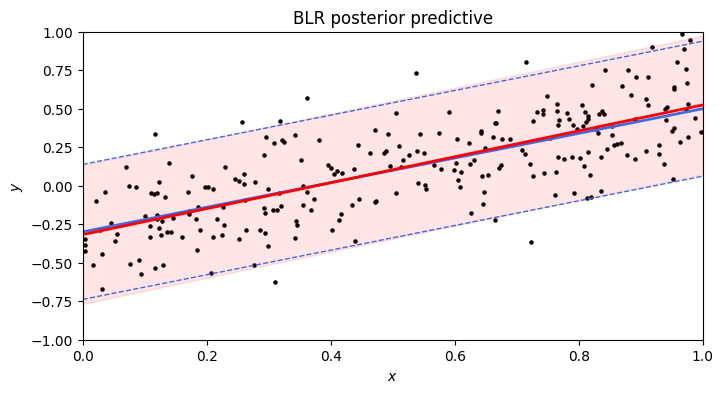

In [41]:
t_crit1 = t.ppf(0.975, df=2*a_n)

plt.figure(figsize=(8,4))
plt.scatter(x, y, s=5, color="black")

plt.fill_between(x_vals, pp_mu_vals-t_crit1*pp_std_vals, pp_mu_vals+t_crit1*pp_std_vals, color=colors[1], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="-")
plt.plot(x_vals, pp_mu_vals, color=colors[1], linewidth=2, linestyle="-")
plt.plot(x_vals, mu_vals-norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
plt.plot(x_vals, mu_vals+norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
plt.xlim(0,1); plt.ylim(-1,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("BLR posterior predictive")
plt.show()

#### Negative log predictive density (NLPD) score

(lower is better)

In [42]:
pp_mu = X @ mu_n
pp_var = b_n / a_n * (1 + np.array([row @ Lambda_n_inv @ row.T for row in X]))
pp_std = np.sqrt(pp_var)

blr_nlpd = -np.sum([np.log(np.array(
    [t.pdf(y[i], 2*a_n, pp_mu[i], pp_std[i]) for i in range(n)]
))])

print(f"BLR NLPD: {blr_nlpd:.4f}")

BLR NLPD: -16.5184


### Explicitly targeting the predicitive distribution

In [43]:
def t_log_pdf(y, x, nu, m0, m1, s0, s1, s2):
    # Parametrization
    nu = nu.to(dtype=torch.float32)
    mean = (m0 + m1*x).to(dtype=torch.float32)
    scale = torch.abs(s0 + s1*x + s2*x**2).to(dtype=torch.float32)  # ensure the scale is positive

    return (torch.lgamma((nu+1)/2) - torch.lgamma(nu/2) - 0.5*torch.log(nu * torch.pi) - torch.log(scale)
            - ((nu+1)/2) * torch.log(1 + ((y - mean)**2) / (nu * scale**2))).to(dtype=torch.float32)


class TDistributionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.nu = nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
        self.m0 = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.m1 = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.s0 = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        self.s1 = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.s2 = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))

    def forward(self, x, y):
        log_pdf = t_log_pdf(y, x, self.nu, self.m0, self.m1, self.s0, self.s1, self.s2)
        return -torch.mean(log_pdf)


In [44]:
x_train = torch.tensor(x, dtype=torch.float16).to(device=device)
y_train = torch.tensor(y, dtype=torch.float16).to(device=device)

model = TDistributionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [45]:
num_epochs = 10_000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = model(x_train, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, NLPD Loss: {loss.item():.4f}")
        print(f"Parameters: nu: {model.nu.item():.2f}, m0: {model.m0.item():.2f}, m1: {model.m1.item():.2f}, s0: {model.s0.item():.2f}, s1: {model.s1.item():.2f}, s2: {model.s2.item():.2f}")


print("\n"+"="*80+"\nLearned parameters:")
print(f"nu: {model.nu.item():.4f}")
print(f"m0: {model.m0.item():.4f}")
print(f"m1: {model.m1.item():.4f}")
print(f"s0: {model.s0.item():.4f}")

Epoch 0, NLPD Loss: 1.0137
Parameters: nu: 10.01, m0: 0.01, m1: 0.01, s0: 0.99, s1: -0.01, s2: -0.01
Epoch 1000, NLPD Loss: -0.0666
Parameters: nu: 14.48, m0: -0.32, m1: 0.85, s0: 0.21, s1: -0.02, s2: 0.04
Epoch 2000, NLPD Loss: -0.0672
Parameters: nu: 18.16, m0: -0.32, m1: 0.85, s0: 0.21, s1: -0.01, s2: 0.03
Epoch 3000, NLPD Loss: -0.0675
Parameters: nu: 21.39, m0: -0.32, m1: 0.84, s0: 0.21, s1: -0.01, s2: 0.03
Epoch 4000, NLPD Loss: -0.0677
Parameters: nu: 24.46, m0: -0.32, m1: 0.85, s0: 0.21, s1: -0.00, s2: 0.03
Epoch 5000, NLPD Loss: -0.0677
Parameters: nu: 27.49, m0: -0.32, m1: 0.85, s0: 0.21, s1: -0.00, s2: 0.03
Epoch 6000, NLPD Loss: -0.0678
Parameters: nu: 30.55, m0: -0.32, m1: 0.84, s0: 0.21, s1: -0.00, s2: 0.03
Epoch 7000, NLPD Loss: -0.0678
Parameters: nu: 33.64, m0: -0.32, m1: 0.85, s0: 0.21, s1: -0.00, s2: 0.03
Epoch 8000, NLPD Loss: -0.0679
Parameters: nu: 36.75, m0: -0.32, m1: 0.84, s0: 0.21, s1: 0.00, s2: 0.03
Epoch 9000, NLPD Loss: -0.0678
Parameters: nu: 39.81, m0: -0

In [46]:
nu, m_0, m_1, s_0, s_1, s_2 = model.nu.item(), model.m0.item(), model.m1.item(), model.s0.item(), model.s1.item(), model.s2.item()

In [47]:
pred_mu_vals = X_vals @ np.array([m_0, m_1])
pred_std_vals = s_0 + s_1*x_vals + s_2*x_vals**2

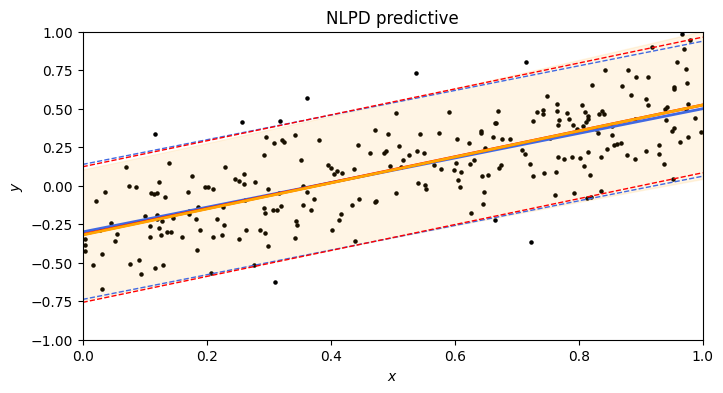

In [48]:
t_crit2 = t.ppf(0.975, df=nu)

plt.figure(figsize=(8,4))
plt.scatter(x, y, s=5, color="black")

plt.fill_between(x_vals, pred_mu_vals-t_crit2*pred_std_vals, pred_mu_vals+t_crit2*pred_std_vals, color=colors[2], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="-")
plt.plot(x_vals, pp_mu_vals, color=colors[1], linewidth=2, linestyle="-")
plt.plot(x_vals, pred_mu_vals, color=colors[2], linewidth=2, linestyle="-")
plt.plot(x_vals, mu_vals-norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
plt.plot(x_vals, mu_vals+norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
plt.plot(x_vals, pp_mu_vals-t_crit1*sigma, color=colors[1], linewidth=1, linestyle="--")
plt.plot(x_vals, pp_mu_vals+t_crit1*sigma, color=colors[1], linewidth=1, linestyle="--")
plt.xlim(0,1); plt.ylim(-1,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("NLPD predictive")
plt.show()

#### NLPD score

In [49]:
pred_mu = X @ np.array([m_0, m_1])
pred_std = s_0 + s_1*x + s_2*x**2

pred_nlpd = -np.sum([np.log(np.array(
    [t.pdf(y[i], nu, pred_mu[i], pred_std[i]) for i in range(n)]
))])

print(f"Direct NLPD: {pred_nlpd:.4f}")

Direct NLPD: -16.9753


### Comparison of predictives

In [57]:
x_point = 0.5
y_vals = np.linspace(-0.1, 0.3, 1000)

pred_pdf_vals = np.array([t.pdf(y, nu, mu, scale**2) for y, mu, scale in zip(y_vals, 
                                                                          np.ones(y_vals.shape[0])*(np.array([1, x_point]) @ np.array([m_0, m_1])),
                                                                          np.ones(y_vals.shape[0])*(s_0 + s_1*x_point + s_2*x_point**2))])

blr_pdf_vals = np.array([t.pdf(y, 2*a_n, mu, scale) for y, mu, scale in zip(y_vals, 
                                                                            np.ones(y_vals.shape[0])*(np.array([1, x_point]) @ mu_n),
                                                                            np.ones(y_vals.shape[0])*(b_n / a_n * (1 + np.array([1, x_point]) @ Lambda_n_inv @ np.array([1, x_point]).T)))])

true_pdf_vals = np.array([norm.pdf(y, mu, var) for y, mu, var in zip(y_vals,
                                                                     np.ones(y_vals.shape[0])*(np.array([1, x_point]) @ beta),
                                                                     np.ones(y_vals.shape[0])*sigma2)])

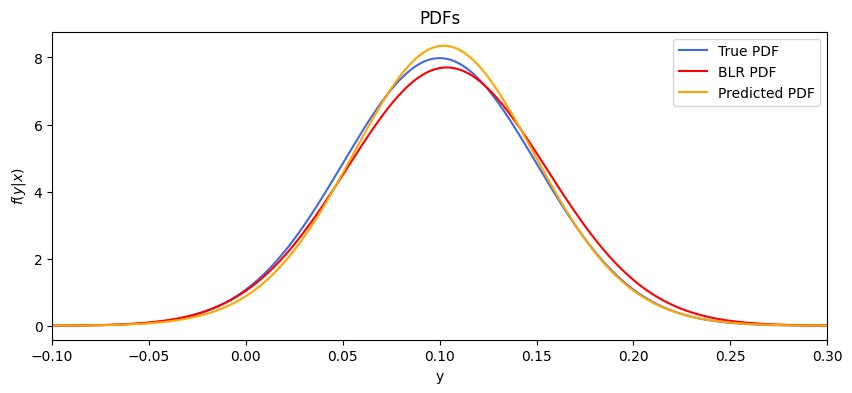

In [58]:
plt.figure(figsize=(10, 4))
plt.plot(y_vals, true_pdf_vals, color=colors[0], label="True PDF")
plt.plot(y_vals, blr_pdf_vals, color=colors[1], label="BLR PDF")
plt.plot(y_vals, pred_pdf_vals, color=colors[2], label="Predicted PDF")
plt.xlabel("y"); plt.ylabel("$f(y | x)$")
plt.xlim(-0.1,0.3)
plt.title("PDFs")
plt.legend()
plt.show()

Directly targeting the predictive seems like just as reasonable an approximation to the true distribution as the BLR posterior.

### Large data limit

Before, we had $n=250$ training points, what happens as $n \to \infty$?

In [64]:
def foo(n=250, num_epochs=10_000):
    # training dataset
    x = np.random.uniform(0, 1, n)
    X = phi(x)
    y = np.matmul(X, beta) + np.random.normal(0, np.sqrt(sigma2), n)


    mu = X @ beta
    std = np.ones(n) * np.sqrt(sigma2)
    # true NLPD
    true_mean_nlpd = -np.mean([np.log(np.array(
        [norm.pdf(y[i], mu[i], std[i]) for i in range(n)]
    ))])
    print(f"\nTrue mean NLPD: {true_mean_nlpd:.4f}")


    # BLR
    Lambda_n = (X.T @ X) + Lambda_0
    Lambda_n_inv = np.linalg.inv(Lambda_n)
    mu_n = Lambda_n_inv @ (X.T @ y + Lambda_0 @ mu_0)
    a_n = a_0 + n/2
    b_n = b_0 + 0.5*((y.T @ y) + (mu_0.T @ Lambda_0 @ mu_0) - (mu_n.T @ Lambda_n @ mu_n))

    # for plotting with BLR
    pp_mu_vals = X_vals @ mu_n 
    pp_var_vals = b_n / a_n * (1 + np.array([row @ Lambda_n_inv @ row.T for row in X_vals]))
    pp_std_vals = np.sqrt(pp_var_vals)

    pp_mu = X @ mu_n
    pp_std = np.sqrt(b_n / a_n * (1 + np.array([row @ Lambda_n_inv @ row.T for row in X])))
    # BLR NLPD
    blr_mean_nlpd = -np.mean([np.log(np.array(
        [t.pdf(y[i], 2*a_n, pp_mu[i], pp_std[i]) for i in range(n)]
    ))])
    print(f"\nBLR mean NLPD: {blr_mean_nlpd:.4f}")


    # directly targeting predictive
    x_train = torch.tensor(x, dtype=torch.float16).to(device=device)
    y_train = torch.tensor(y, dtype=torch.float16).to(device=device)
    model = TDistributionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model(x_train, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, NLPD Loss: {loss.item():.4f}")

    print("\nLearned parameters:")
    print(f"nu: {model.nu.item():.4f}")
    print(f"m0: {model.m0.item():.4f}")
    print(f"m1: {model.m1.item():.4f}")
    print(f"s0: {model.s0.item():.4f}")

    nu, m_0, m_1, s_0, s_1, s_2 = model.nu.item(), model.m0.item(), model.m1.item(), model.s0.item(), model.s1.item(), model.s2.item()

    # for plotting with predictive
    pred_mu_vals = X_vals @ np.array([m_0, m_1])
    pred_std_vals = s_0 + s_1*x_vals + s_2*x_vals**2

    pred_mu = X @ np.array([m_0, m_1])
    pred_std = s_0 + s_1*x + s_2*x**2
    # predictive NLPD
    pred_mean_nlpd = -np.mean([np.log(np.array(
        [t.pdf(y[i], nu, pred_mu[i], pred_std[i]) for i in range(n)]
    ))])
    print(f"\nDirect mean NLPD: {pred_mean_nlpd:.4f}")


    # Plot
    t_crit1 = t.ppf(0.975, df=2*a_n)
    t_crit2 = t.ppf(0.975, df=nu)
    plt.figure(figsize=(8,4))
    plt.scatter(x, y, s=5, color="black")

    plt.fill_between(x_vals, pred_mu_vals-t_crit2*pred_std_vals, pred_mu_vals+t_crit2*pred_std_vals, color=colors[2], alpha=0.1)
    plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="-")
    plt.plot(x_vals, pp_mu_vals, color=colors[1], linewidth=2, linestyle="-")
    plt.plot(x_vals, pred_mu_vals, color=colors[2], linewidth=2, linestyle="-")
    plt.plot(x_vals, mu_vals-norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
    plt.plot(x_vals, mu_vals+norm_crit*sigma, color=colors[0], linewidth=1, linestyle="--")
    plt.plot(x_vals, pp_mu_vals-t_crit1*pp_std_vals, color=colors[1], linewidth=1, linestyle="--")
    plt.plot(x_vals, pp_mu_vals+t_crit1*pp_std_vals, color=colors[1], linewidth=1, linestyle="--")
    plt.xlim(0,1); plt.ylim(-1,1)
    plt.xlabel("$x$"); plt.ylabel("$y$")
    plt.title("NLPD predictive")
    plt.show()
    


True mean NLPD: -0.0953

BLR mean NLPD: -0.0956
Epoch 0, NLPD Loss: 1.0037
Epoch 1000, NLPD Loss: -0.1015
Epoch 2000, NLPD Loss: -0.1032
Epoch 3000, NLPD Loss: -0.1041
Epoch 4000, NLPD Loss: -0.1047
Epoch 5000, NLPD Loss: -0.1052
Epoch 6000, NLPD Loss: -0.1055
Epoch 7000, NLPD Loss: -0.1058
Epoch 8000, NLPD Loss: -0.1060
Epoch 9000, NLPD Loss: -0.1062

Learned parameters:
nu: 64.5539
m0: -0.2783
m1: 0.7673
s0: 0.1706

Direct mean NLPD: -0.1064


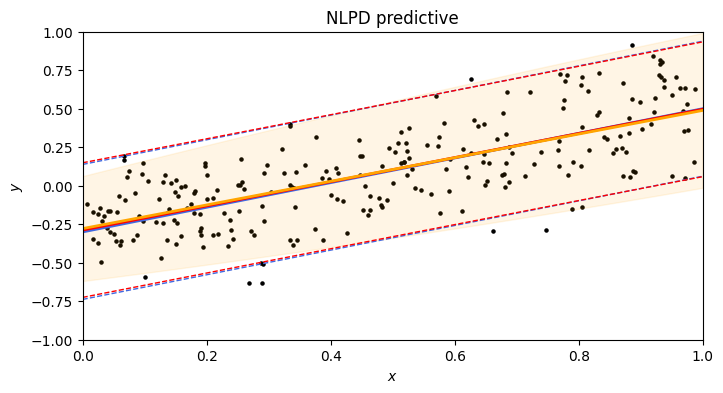

In [65]:
foo(250)


True mean NLPD: -0.0620

BLR mean NLPD: -0.0629
Epoch 0, NLPD Loss: 1.0034
Epoch 1000, NLPD Loss: -0.0618
Epoch 2000, NLPD Loss: -0.0626
Epoch 3000, NLPD Loss: -0.0630
Epoch 4000, NLPD Loss: -0.0633
Epoch 5000, NLPD Loss: -0.0635
Epoch 6000, NLPD Loss: -0.0636
Epoch 7000, NLPD Loss: -0.0637
Epoch 8000, NLPD Loss: -0.0638
Epoch 9000, NLPD Loss: -0.0638
Epoch 10000, NLPD Loss: -0.0639
Epoch 11000, NLPD Loss: -0.0639
Epoch 12000, NLPD Loss: -0.0639
Epoch 13000, NLPD Loss: -0.0639
Epoch 14000, NLPD Loss: -0.0640
Epoch 15000, NLPD Loss: -0.0639
Epoch 16000, NLPD Loss: -0.0639
Epoch 17000, NLPD Loss: -0.0640
Epoch 18000, NLPD Loss: -0.0640
Epoch 19000, NLPD Loss: -0.0640

Learned parameters:
nu: 115.5591
m0: -0.2927
m1: 0.7761
s0: 0.2070

Direct mean NLPD: -0.0640


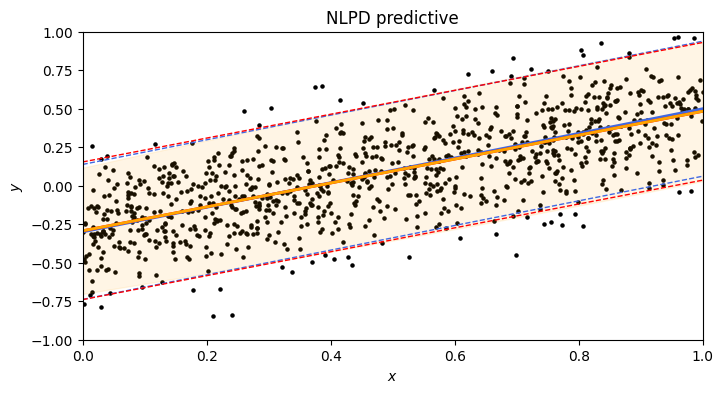

In [66]:
foo(1_000, num_epochs=20_000)


True mean NLPD: -0.0683

BLR mean NLPD: -0.0685
Epoch 0, NLPD Loss: 1.0057
Epoch 1000, NLPD Loss: -0.0682
Epoch 2000, NLPD Loss: -0.0687
Epoch 3000, NLPD Loss: -0.0689
Epoch 4000, NLPD Loss: -0.0690
Epoch 5000, NLPD Loss: -0.0691
Epoch 6000, NLPD Loss: -0.0691
Epoch 7000, NLPD Loss: -0.0691
Epoch 8000, NLPD Loss: -0.0691
Epoch 9000, NLPD Loss: -0.0691
Epoch 10000, NLPD Loss: -0.0691
Epoch 11000, NLPD Loss: -0.0691
Epoch 12000, NLPD Loss: -0.0691
Epoch 13000, NLPD Loss: -0.0691
Epoch 14000, NLPD Loss: -0.0691
Epoch 15000, NLPD Loss: -0.0691
Epoch 16000, NLPD Loss: -0.0691
Epoch 17000, NLPD Loss: -0.0691
Epoch 18000, NLPD Loss: -0.0691
Epoch 19000, NLPD Loss: -0.0691

Learned parameters:
nu: 33.1586
m0: -0.2978
m1: 0.7962
s0: 0.2161

Direct mean NLPD: -0.0691


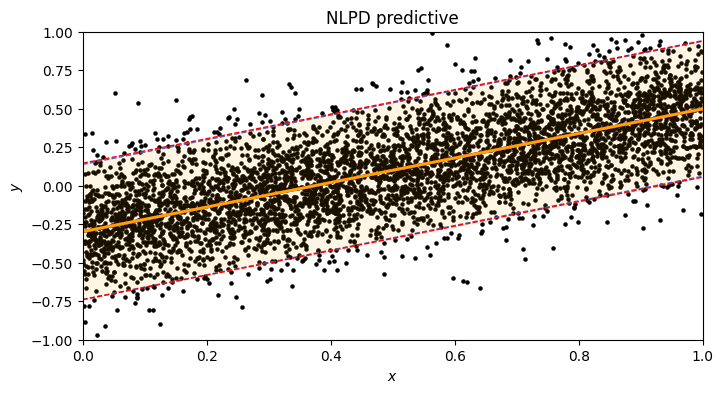

In [67]:
foo(5_000, num_epochs=20_000)